In [5]:
import IPython, numpy as np, scipy as sp, matplotlib.pyplot as plt, matplotlib, sklearn, librosa
import scipy.io.wavfile
import os
from scipy.fftpack import fft
from scipy.signal import hann
from IPython.display import Audio
%matplotlib inline

In [6]:
def wavwrite(filepath, data, sr, norm=True, dtype='int16',):
    '''
    Write wave file using scipy.io.wavefile.write, converting from a float (-1.0 : 1.0) numpy array to an integer array
    
    Parameters
    ----------
    filepath : str
        The path of the output .wav file
    data : np.array
        The float-type audio array
    sr : int
        The sampling rate
    norm : bool
        If True, normalize the audio to -1.0 to 1.0 before converting integer
    dtype : str
        The output type. Typically leave this at the default of 'int16'.
    '''
    if norm:
        data /= np.max(np.abs(data))
    data = data * np.iinfo(dtype).max
    data = data.astype(dtype)
    scipy.io.wavfile.write(filepath, sr, data)
    
def stft(signal, window_size, hop_size, window_type = 'hann'):
    """
    Computes the short term fourier transform of a 1-D numpy array, where the array 
    is windowed into a set of subarrays, each of length window_size. The distance between
    window centers (in samples) is given by hop_size. The type of window applied is
    determined by window_type. This returns a 2-D numpy array where the ith column
    is the FFT of the ith window. Each column contains an array of complex values.
    
    Input Parameters
    ----------------
    signal: The 1-d (complex or real) numpy array containing the signal
    window_size: an integer scalar specifying the number of samples in a window
    hop_size: an integer specifying the number of samples between the start of adjacent windows
    window_type: a string specifying one of two "hann" or "rectangular"
    
    Returns
    -------
    a 2D numpy array of complex numbers where the array column is the FFT of the ith window,
    and the jth element in the ith column is the jth frequency of analysis.
    """
    # figure out how many hops
    length_to_cover_with_hops = len(signal) - window_size;
    assert (length_to_cover_with_hops >= 0), "window_size cannot be longer than the signal to be windowed"
    num_hops = 1 + length_to_cover_with_hops/hop_size;
    
    # make our window function
    if window_type == 'hann':
        window = hann(window_size)
    elif window_type=='rectangular':
        window = np.ones(window_size)
    else:
        raise Exception('Invalid window type. Must be "hann" or "rectangular".')
    
    stft = [0]*num_hops
    # fill the array with values 
    for hop in range(num_hops):
        start = hop*hop_size
        end = start + window_size
        unwindowed_sound = signal[start:end]
        windowed_sound =  unwindowed_sound * window
        stft[hop]= fft(windowed_sound, window_size) 
    return np.array(stft)

def plot_audio(x, sr, figsize=(16,4)):
    """
    A simple audio plotting function
    
    Parameters
    ----------
    x: np.ndarray
        Audio signal to plot
    sr: int
        Sample rate
    figsize: tuple
        A duple representing the figure size (xdim,ydim)
    """
    length = float(x.shape[0]) / sr
    t = np.linspace(0,length,x.shape[0])
    plt.figure(figsize=figsize)
    plt.plot(t, x)
    plt.ylabel('Amplitude')
    plt.xlabel('Time (s)')
    plt.show()
    
def spectrogram(signal, window_size, hop_size, sample_rate, window_type = 'hann', display = True ):
    """
    Computes the short term fourier transform of a 1-D numpy array, where the array 
    is windowed into a set of subarrays, each of length window_size. The distance between
    window centers (in samples) is given by hop_size. The type of window applied is
    determined by window_type. This creates a 2-D numpy array where the ith column
    is the FFT of the ith window. Each column contains an array of complex values.
    It then creates a magnitude spectrogram of the signal and plots it on the screen.
    Here, the vertical dimension is frequency (in Hz), the horizontal dimension is time
    (in seconds), brightness corresponds to amplitude (in dB). Only frequencies up to
    the Nyquist rate are displayed.
    
    Input Parameters
    ----------------
    signal: The 1-d (complex or real) numpy array containing the signal
    window_size: an integer scalar specifying the number of samples in a window
    hop_size: an integer specifying the number of samples between the start of adjacent windows
    sample_rate: an integer giving the sample rate of the input signal, in Hz
    window_type: a string specifying one of two "hann" or "rectangular"
    display: a bool. If set to True, it plots the spectrogram. Else it does not.
    
    Returns
    -------
    an output tuple with 3 items
    
    sgram:  a 2-D numpy array of real-valued numbers that contains the magnitude spectrogram
           sgram[t,f] is the magnitude at time t and frequency f. This only contains values
           up to the nyquist frequency
    times: a 1-D numpy array of non-negative real-values that gives the times,  
           times[t] gives the start time of the tth window in seconds
    freqs: a 1-D numpy array  of non-negative real values. freqs[f] gives the fth
           frequency of analysis in Hz, up to the nyquist frequency
           
    Calling Example
    ---------------
    sgram,times,freqs = spectrogram(signal, window_size, hop_size, sample_rate )

    """ 

    # get the stft
    X = stft(signal, window_size, hop_size, window_type)

    # figure out what my window start times are
    times = np.arange(len(X))
    hop_in_secs = hop_size/(1.0 * sample_rate)
    times = times * hop_in_secs
    
    # chop off everything above the nyquist rate & rotate for display    
    X = np.rot90(X,3)
    sgram = np.array(X[0:len(X)/2])

    # figure out what my frequencies of analysis are..
    analysis_f0 = sample_rate/window_size
    freqs = np.arange(len(sgram)) * analysis_f0
    
    # turn the complex values into magnitudes and putit into a log scale 
    sgram = np.abs(sgram) + 0.00000000000001  # this prevents taking the log of 0
    log_sgram = 20 * np.log10(sgram)
 
    # plot the spectrum 
    if display: 
        plt.figure()
        x_coord = np.tile(times,(len(freqs),1)) 
        x_coord = np.fliplr(x_coord)
        y_coord = np.tile(freqs,(len(times),1))
        y_coord = np.rot90(y_coord,3)
        
        plt.pcolor(x_coord,y_coord,log_sgram)
        # set the limits of the plot to the limits of the data
        plt.axis([x_coord.min(), x_coord.max(), y_coord.min(), y_coord.max()])

        plt.title('Magnitude Spectrogram in dB')
        plt.xlabel('time in seconds')
        plt.ylabel('frequency in Hz')
        cbar = plt.colorbar()

    return np.rot90(log_sgram,1), times, freqs

def make_sinewave(f, t, sr):
    vals = np.array([2 * np.pi * x * f / sr for x in range(int(sr * t))])
    return np.sin(vals)

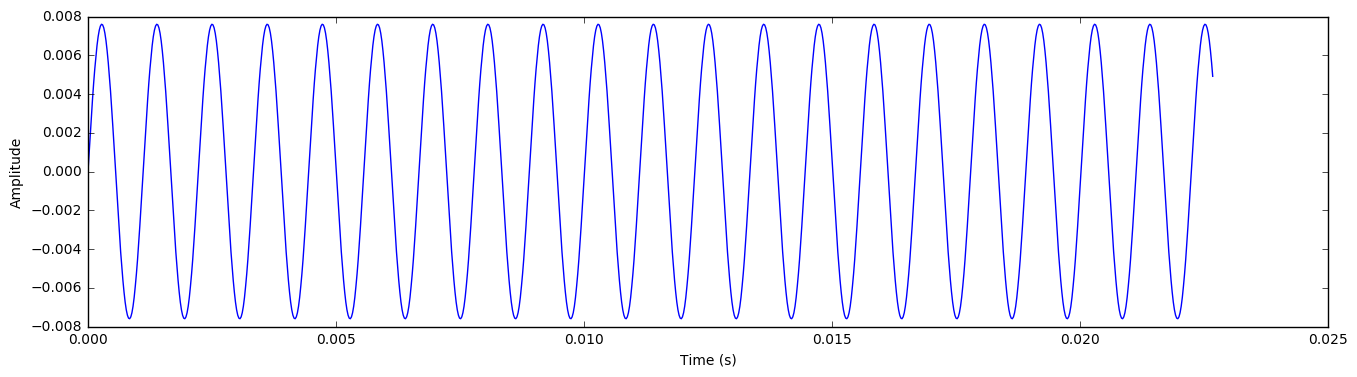

In [7]:
sample_rate=44100
window_size=2048
hop_size=1024

def encode(data_file):
    signal = make_sinewave(900, 100, sample_rate)
    spec = librosa.core.stft(signal, 2048, 1024)

    with open(data_file) as dfile:
        d = dfile.read(1)
        i = 1
        spec[0][20] = np.float64(os.path.getsize(data_file))/2**16
        while d:
            h = int(d.encode("hex"), 16)
            spec[i][h] = np.max(np.abs(spec[i])) * 200
            d = dfile.read(1)
            i += 1

    return librosa.core.istft(spec, 1024, 2048)

wavwrite('encode.wav', encode('test.txt'), sample_rate)
encode, sr = librosa.load('encode.wav', sr=sample_rate, duration=30)
plot_audio(encode[:1000], sr)
Audio(encode, rate=sr)

In [8]:
def decode(wavfile):
    signal, sr = librosa.load(wavfile, sr=44100)
    spec = librosa.core.stft(signal, 2048, 1024)
    message = ""

    for i in range(1, 139):
        h = np.argmax(np.abs(spec[i]))
        
        while h > 256:
            spec[i][h] = 0
            h = np.argmax(np.abs(spec[i]))

        char = str(chr(h))
        message += char
    return message

print decode('encode.wav')

Lorem ipsum dooor sit amet, consectttu  adiipscing elit. Cras eu gravida diam. Etiam nnn maurisssagiiiis, faciiiiss enim ac, aliquam enim.
